# Network Community Detection

## Brain Network Community Detection

Load brain network graph data to Network dataclass

In [3]:
from QHyper.problems.community_detection import BrainNetwork


path = "../QHyper/problems/network_communities/brain_community_data"
data_name = "Edge_AAL90_Binary"

brain_network = BrainNetwork(input_data_dir=path, input_data_name=data_name)

<class 'networkx.utils.decorators.argmap'> compilation 5:5: FutureWarning: modularity_matrix will return a numpy array instead of a matrix in NetworkX 3.0.


Run the problem with DQM for k different communities to detect, each r times

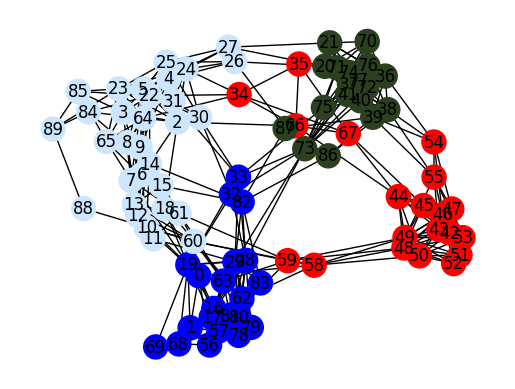

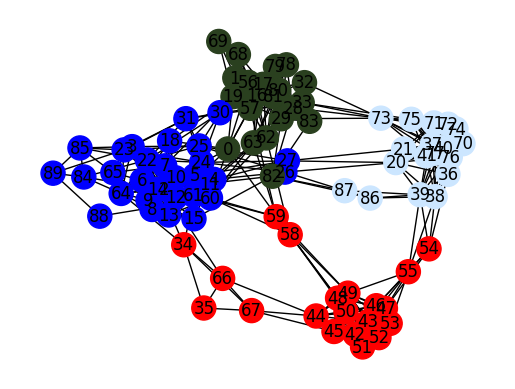

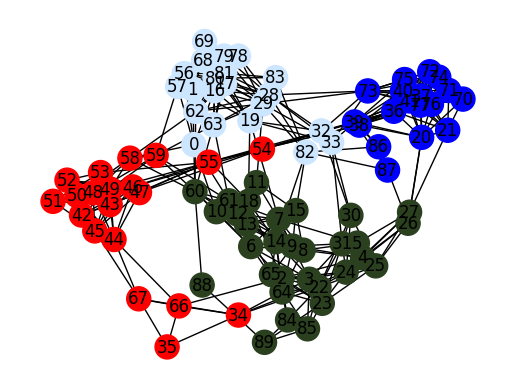

In [4]:
from QHyper.solvers.dqm import DQM
from QHyper.problems.network_communities.utils import (
    ResultsFrame,
    draw_communities_from_graph,
    communities_to_csv,
    results_to_csv,
)
from QHyper.problems.community_detection import CommunityDetectionProblem
import time
import networkx.algorithms.community as nx_comm


folder = "./demo_output"
data_name = "Edge_AAL90_Binary"

N_communities = [4]
runs = range(3)
qa_results_dict = {k: ResultsFrame() for k in N_communities}
louvain_results_dict = {k: ResultsFrame() for k in N_communities}

for k in N_communities:
    brain_problem = CommunityDetectionProblem(brain_network, k)
    qa_results = qa_results_dict[k]
    louvain_results = louvain_results_dict[k]

    for r in runs:
        # Quantum
        brain_dqm = DQM(brain_problem, time=5)
        brain_dqm_sampleset = brain_dqm.solve_from_graph()
        lowest_sample = brain_dqm_sampleset.first

        qa_results.samples.append(lowest_sample.sample)
        qa_results.energies.append(lowest_sample.energy)
        qa_results.run_times.append(brain_dqm_sampleset.info["run_time"])
        qa_results.calculate_append_communities(lowest_sample.sample, k)
        qa_results.calculate_append_communities_counts(lowest_sample.sample, k)
        qa_results.modularity_scores.append(
            nx_comm.modularity(brain_problem.G, qa_results.communities[r])
        )

        # Classical
        start = time.time()
        louvain_communities = nx_comm.louvain_communities(
            brain_problem.G, resolution=0.5, seed=None
        )  # , seed=123)
        end = time.time()
        sample_like = louvain_results.louvain_communities_to_sample_like(
            louvain_communities
        )

        louvain_results.samples.append(sample_like)
        louvain_results.energies.append(None)
        louvain_results.run_times.append(end - start)
        louvain_results.calculate_append_communities(
            sample_like, len(louvain_communities)
        )
        louvain_results.calculate_append_communities_counts(
            sample_like, len(louvain_communities)
        )
        louvain_results.modularity_scores.append(
            nx_comm.modularity(brain_problem.G, louvain_results.communities[r])
        )

        # Save results
        # Draw qa comm graph in each run
        qa_img_path = f"{folder}/{data_name}graph{k}_{r}.png"
        draw_communities_from_graph(
            brain_problem, qa_results.samples[r], qa_img_path
        )
        # Save current qa communities to csv
        qa_clustering_path = f"{folder}/{data_name}clustering{k}_{r}.csv"
        communities_to_csv(
            brain_problem, qa_results.samples[r], qa_clustering_path
        )

    results_path = f"{folder}/{data_name}_N{k}runs.csv"
    results_to_csv(qa_results, louvain_results, results_path)

Let's take a look at the partitioning stats

In [5]:
import pandas as pd

df_qa = pd.DataFrame.from_dict(qa_results_dict[4].__dict__)
df_lou = pd.DataFrame.from_dict(louvain_results_dict[4].__dict__)

In [6]:
df_qa

,samples,run_times,communities,communities_counts,N_communities,modularity_scores,energies
0,"{0: 0, 1: 0, 2: 3, 3: 3, 4: 3, 5: 3, 6: 3, 7: ...",5185066,"[{0, 1, 16, 17, 19, 28, 29, 32, 33, 56, 57, 62...","[21.0, 20.0, 18.0, 31.0]",4,0.642478,-269.148418
1,"{0: 2, 1: 2, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: ...",5130851,"[{2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, ...","[31.0, 20.0, 21.0, 18.0]",4,0.642478,-269.148418
2,"{0: 3, 1: 3, 2: 2, 3: 2, 4: 2, 5: 2, 6: 2, 7: ...",4963946,"[{36, 37, 38, 39, 40, 41, 70, 71, 72, 73, 74, ...","[18.0, 20.0, 31.0, 21.0]",4,0.642478,-269.148418


In [7]:
df_lou

,samples,run_times,communities,communities_counts,N_communities,modularity_scores,energies
0,"{0: 0, 1: 2, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: ...",0.008001,"[{0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 1...","[32.0, 18.0, 20.0, 20.0]",4,0.641119,None
1,"{0: 3, 1: 2, 2: 3, 3: 3, 4: 3, 5: 3, 6: 3, 7: ...",0.007995,"[{36, 37, 38, 39, 40, 41, 70, 71, 72, 73, 74, ...","[18.0, 20.0, 20.0, 32.0]",4,0.641119,None
2,"{0: 0, 1: 2, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: ...",0.006000,"[{0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 1...","[32.0, 20.0, 20.0, 18.0]",4,0.641119,None


As we can see, QA achieved higher modularity scores in each round.

In [8]:
nodes = list(df_qa.samples.values[0].keys())

qa_values_r0 = list(df_qa.samples.values[0].values())
qa_values_r1 = list(df_qa.samples.values[1].values())
qa_values_r2 = list(df_qa.samples.values[2].values())

lou_values_r0 = list(df_lou.samples.values[0].values())
lou_values_r1 = list(df_lou.samples.values[1].values())
lou_values_r2 = list(df_lou.samples.values[2].values())

qa_comms_r0 = df_qa.communities.values[0]
qa_comms_r1 = df_qa.communities.values[1]
qa_comms_r2 = df_qa.communities.values[2]

qa_samples_r0 = df_qa.samples.values[0]
qa_samples_r1 = df_qa.samples.values[1]
qa_samples_r2 = df_qa.samples.values[2]

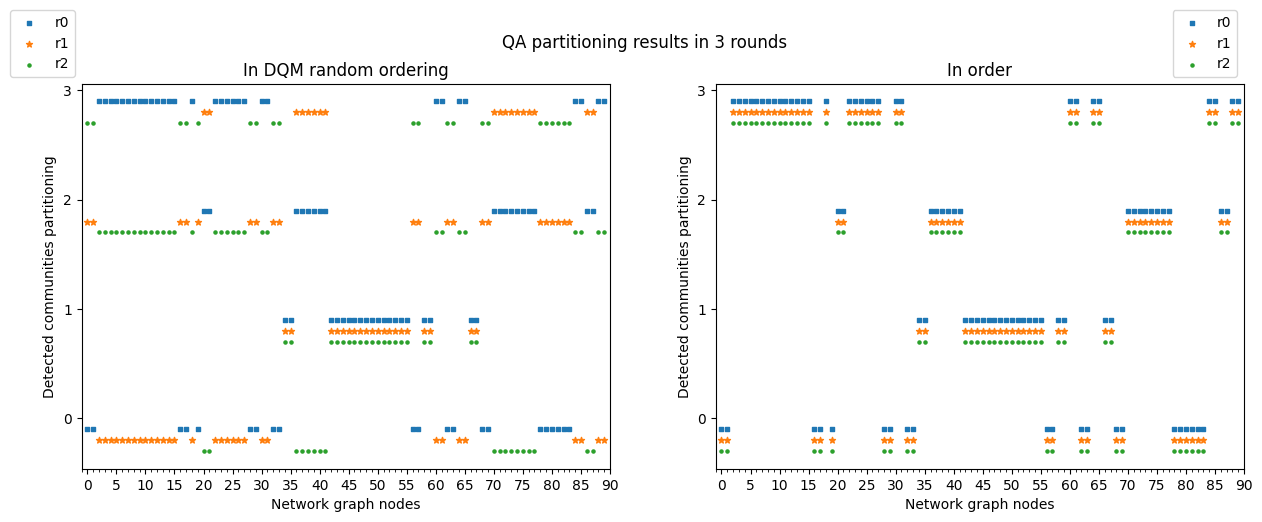

In [9]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from QHyper.problems.network_communities.stats import StatsModule


f, ax = plt.subplots(1, 2, figsize=(15, 5))

# Tickers
x_major_ticker = mpl.ticker.MultipleLocator(5)
x_minor_ticker = mpl.ticker.MultipleLocator(1)

# Titles
plt.suptitle("QA partitioning results in 3 rounds")
ax[0].set_title("In DQM random ordering")
ax[1].set_title("In order")

# Ticks, lims, tickers, text annotations
for a in ax:
    a.set_xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90])
    a.set_yticks(np.unique(qa_values_r0).flatten())
    a.set_xlim(-1, 90)
    a.xaxis.set_major_locator(x_major_ticker)
    a.xaxis.set_minor_locator(x_minor_ticker)

    a.set_xlabel("Network graph nodes")
    a.set_ylabel("Detected communities partitioning")

# Scatter
values = [qa_values_r0, qa_values_r1, qa_values_r2]
samples = [qa_samples_r0, qa_samples_r1, qa_samples_r2]
communities = [qa_comms_r0, qa_comms_r1, qa_comms_r2]

ref_sample = qa_samples_r0
ref_comm = qa_comms_r0

standarized_ordering = [
    renamed_sample
    for renamed_sample, _ in [
        StatsModule.standarize_sample_cluster_ordering(
            sam, ref_sample, comm, ref_comm
        )
        for sam, comm in zip(samples, communities)
    ]
]
standarized_values = [v.values() for v in [s for s in standarized_ordering]]

off_unit = 0.1
offsets = [off_unit * i for i in [1, 2, 3]]
markers = ["s", "*", "o"]
labels = ["r0", "r1", "r2"]
ss = [5, 20, 5]

for i, vals in enumerate(values):
    offset, s, m, l = offsets[i], ss[i], markers[i], labels[i]
    ax[0].scatter(nodes, [v - offset for v in vals], s=s, marker=m, label=l)
ax[0].legend(loc=4, bbox_to_anchor=(0, 1))

for i, vals in enumerate(standarized_values):
    offset, s, m, l = offsets[i], ss[i], markers[i], labels[i]
    ax[1].scatter(nodes, [v - offset for v in vals], s=s, marker=m, label=l)
ax[1].legend(loc=4, bbox_to_anchor=(1, 1));

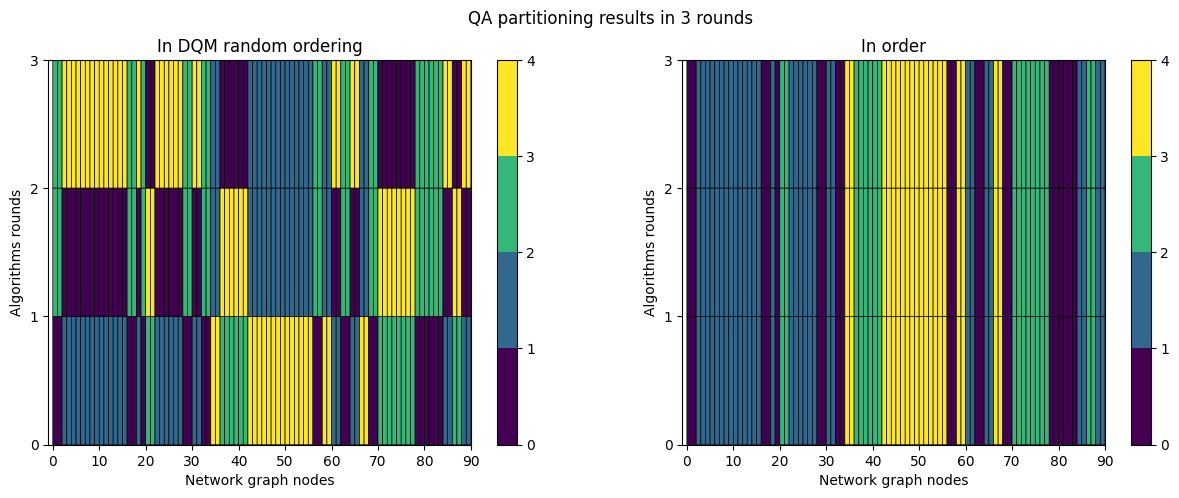

In [10]:
f, ax = plt.subplots(1, 2, figsize=(15, 5))

# Data
xv, yv = np.meshgrid(nodes, [0, 1, 2])

values = [qa_values_r0, qa_values_r1, qa_values_r2]
samples = [qa_samples_r0, qa_samples_r1, qa_samples_r2]
communities = [qa_comms_r0, qa_comms_r1, qa_comms_r2]

ref_sample = qa_samples_r0
ref_comm = qa_comms_r0

standarized_ordering = [
    renamed_sample
    for renamed_sample, _ in [
        StatsModule.standarize_sample_cluster_ordering(
            sam, ref_sample, comm, ref_comm
        )
        for sam, comm in zip(samples, communities)
    ]
]
standarized_values = [v.values() for v in [s for s in standarized_ordering]]

# Titles
plt.suptitle("QA partitioning results in 3 rounds")
ax[0].set_title("In DQM random ordering")
ax[1].set_title("In order")
for a in ax:
    a.set_xlabel("Network graph nodes")
    a.set_ylabel("Algorithms rounds")

# 1st subplot
z = np.array([[val[n] for n in nodes] for val in values])
heatmap = ax[0].pcolor(z, edgecolors="k", linewidths=0.5)
plt.colorbar(heatmap, boundaries=[0, 1, 2, 3, 4], values=[0, 1, 2, 3])
ax[0].set_yticks(np.unique(z))
ax[0].set_xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90])
ax[0].set_xlim(-1, 90)

# 2nd subplot
z = np.array([[list(val)[n] for n in nodes] for val in standarized_values])
heatmap = ax[1].pcolor(z, edgecolors="k", linewidths=0.5)
plt.colorbar(heatmap, boundaries=[0, 1, 2, 3, 4], values=[0, 1, 2, 3])
ax[1].set_yticks(np.unique(z))
ax[1].set_xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90])
ax[1].set_xlim(-1, 90);